<a href="https://colab.research.google.com/github/znjubery/hpc-ai-intro_2025/blob/main/PyTorch_CIFAR10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neural Network and Deep Learning with PyTorch (CIFAR-10)


For this exercise, we will use the CIFAR10 dataset. It has the classes: ‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’, ‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’. The images in CIFAR-10 are of size 3x32x32, i.e. 3-channel color images of 32x32 pixels in size.

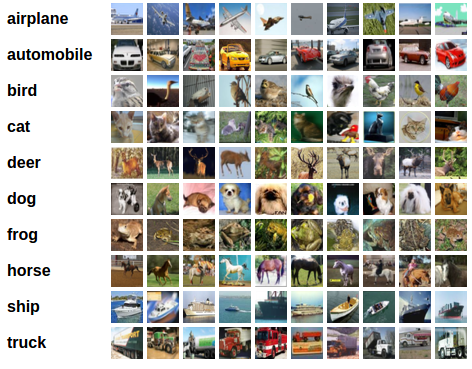


The dataset is divided into five training batches and one test batch, each with 10000 images. The test batch contains exactly 1000 randomly-selected images from each class. The training batches contain the remaining images in random order, but some training batches may contain more images from one class than another. Between them, the training batches contain exactly 5000 images from each class.

In [ ]:
# Display versions of libraries
import torch
import torchvision
import numpy as np
import matplotlib
import sklearn
import itertools  # Note: itertools is part of the Python standard library
import sys

print(f"Python Version: {sys.version}")
print(f"Torch Version: {torch.__version__}")
print(f"Torchvision Version: {torchvision.__version__}")
print(f"Numpy Version: {np.__version__}")
print(f"Matplotlib Version: {matplotlib.__version__}")
print(f"Sklearn Version: {sklearn.__version__}")


Python Version: 3.10.12 (main, Sep 11 2024, 15:47:36) [GCC 11.4.0]
Torch Version: 2.5.1+cu121
Torchvision Version: 0.20.1+cu121
Numpy Version: 1.26.4
Matplotlib Version: 3.8.0
Sklearn Version: 1.5.2


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix

from torch.utils.tensorboard import SummaryWriter

In [ ]:
print(torch.__version__)
print(torchvision.__version__)

2.5.1+cu121
0.20.1+cu121


In [ ]:
!python --version

Python 3.10.12


## Loading the CIFAR-10 data and pre-processing

In [ ]:
transform =transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


train_set = torchvision.datasets.CIFAR10(root = './data', train=True,  transform=transform, download=True)
train_loader = torch.utils.data.DataLoader(train_set, batch_size = 4, shuffle=True)

test_set = torchvision.datasets.CIFAR10(root = './data', train=False, transform=transform, download=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=4, shuffle=False)

100%|██████████| 170M/170M [00:13<00:00, 12.8MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Let's view some of the training images in the way they are passed as batches to the Neural Network during the training process.

torch.Size([4, 3, 32, 32])
torch.Size([4])
labels: tensor([3, 5, 3, 5])


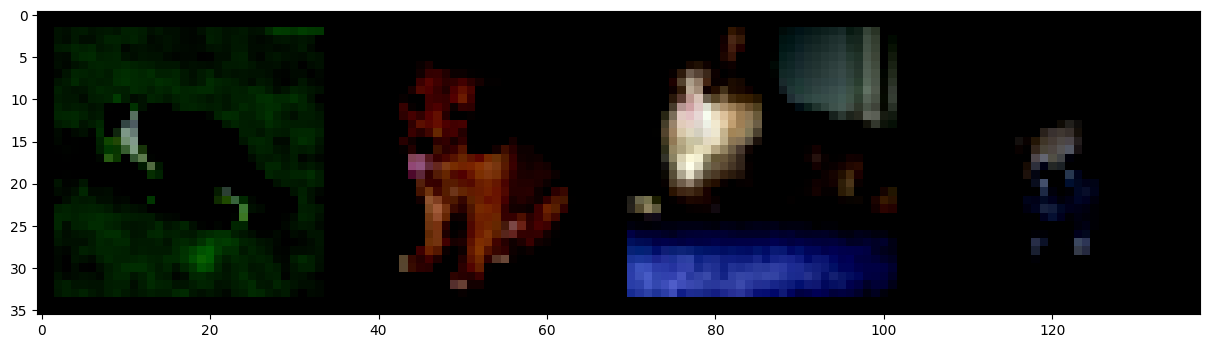

In [ ]:
batch = next(iter(train_loader))

images, labels = batch

print(images.shape)
print(labels.shape)
grid = torchvision.utils.make_grid(images, nrow=10)

plt.figure(figsize=(15,15))
plt.imshow(grid.permute(1,2,0))

print('labels:', labels)

## Neural Network and PyTorch design

In [ ]:
class Network(nn.Module):
  def __init__(self):
    super(Network,self).__init__()
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5)
    self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)

    self.fc1 = nn.Linear(in_features=16*5*5, out_features=120)
    self.fc2 = nn.Linear(in_features=120, out_features=84)
    self.out = nn.Linear(in_features=84, out_features=10)

  def forward(self, t):
    #Layer 1
    t = t
    #Layer 2
    t = self.conv1(t)
    t = F.relu(t)
    t = F.max_pool2d(t, kernel_size=2, stride=2)#output shape : (6,14,14)
    #Layer 3
    t = self.conv2(t)
    t = F.relu(t)
    t = F.max_pool2d(t, kernel_size=2, stride=2)#output shape : (16,5,5)
    #Layer 4
    t = t.reshape(-1, 16*5*5)
    t = self.fc1(t)
    t = F.relu(t)#output shape : (1,120)
    #Layer 5
    t = self.fc2(t)
    t = F.relu(t)#output shape : (1, 84)
    #Layer 6/ Output Layer
    t = self.out(t)#output shape : (1,10)

    return t

network = Network()

## Training the Neural Network
Defining a Loss Function and a Optimizer. For more details on Optimizer, please click [here](https://https://sites.google.com/view/saptarshidatta/knowledge-base/optimizer).

In [ ]:
optimizer = optim.Adam(network.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0)

In [ ]:
for epoch in range(5):

  total_correct = 0
  total_loss = 0
  for batch in train_loader: #Get batch
    images, labels = batch #Unpack the batch into images and labels

    preds = network(images) #Pass batch
    loss = F.cross_entropy(preds, labels) #Calculate Loss

    optimizer.zero_grad()
    loss.backward() #Calculate gradients
    optimizer.step() #Update weights

    total_loss += loss.item()
    total_correct += preds.argmax(dim=1).eq(labels).sum().item()

  print('epoch:', epoch, "total_correct:", total_correct, "loss:", total_loss)

print('>>> Training Complete >>>')

epoch: 0 total_correct: 21997 loss: 19187.555031273514
epoch: 1 total_correct: 27183 loss: 15948.817900050431
epoch: 2 total_correct: 29168 loss: 14681.239316655323
epoch: 3 total_correct: 30657 loss: 13799.194959904999
epoch: 4 total_correct: 31516 loss: 13176.194003587123
>>> Training Complete >>>


Let's quickly save the model, we just trained.


In [ ]:
PATH = './cifar_net.pth'
torch.save(network.state_dict(), PATH)

## Predictions
We will define a function to get all predictions at once. Now, let's load our Saved Model. Please note that saving and re-loading the model wasn’t necessary here, we only did it to illustrate how to do so.

In [ ]:
network = Network()
network.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [ ]:
@torch.no_grad()
def get_all_preds(model, loader):
  all_preds = torch.tensor([])
  for batch in loader:
    images, labels = batch

    preds = model(images)
    all_preds = torch.cat((all_preds, preds) ,dim=0)

  return all_preds

In [ ]:
test_preds = get_all_preds(network, test_loader)
actual_labels = torch.Tensor(test_set.targets)
preds_correct = test_preds.argmax(dim=1).eq(actual_labels).sum().item()

print('total correct:', preds_correct)
print('accuracy:', preds_correct / len(test_set))

total correct: 6083
accuracy: 0.6083


The model predicted the label with 61 % accuracy, which is not that great. Next, we will develop a confusion matrix which will demonstrate, in which particular areas our model is performing poorly.

## Confusion Matrix

In [ ]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[656  29  52  42  45  14   7  18  77  60]
 [ 32 681   5  28   7   5   8  12  37 185]
 [ 72  11 366 134 181 120  50  36  13  17]
 [ 15   9  34 473 108 230  43  45  16  27]
 [ 21   7  25 110 630  70  42  81   9   5]
 [ 10   3  29 207  75 570  15  70   6  15]
 [  4  11  39  94 122  48 653  12   4  13]
 [ 10   2  16  88 103 122   3 638   3  15]
 [112  46  13  30  17  16   5  10 667  84]
 [ 34  82   9  43  11  13   6  26  27 749]]


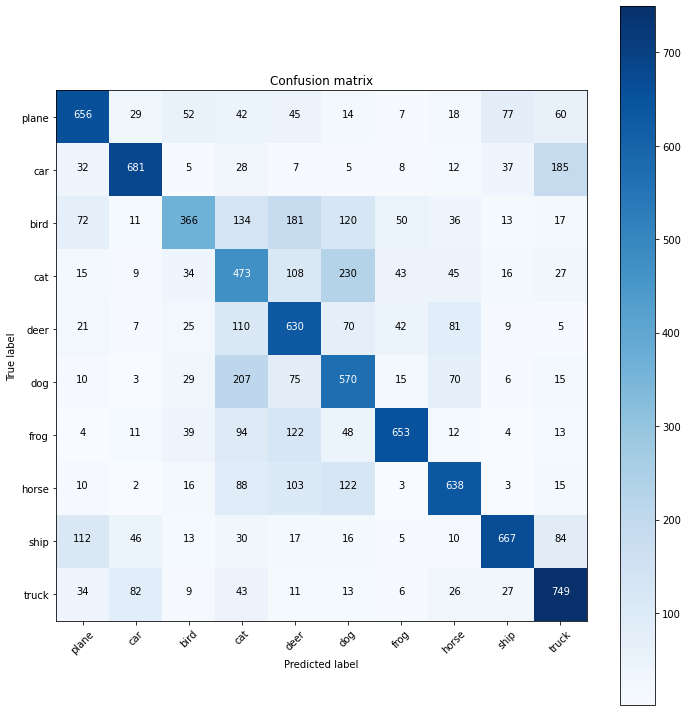

In [ ]:
cm = confusion_matrix(test_set.targets, test_preds.argmax(dim=1))
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, classes)